In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U "flwr[simulation]" "ray[default]" --extra-index-url https://pypi.ray.io

Looking in indexes: https://pypi.org/simple, https://pypi.ray.io
INFO: pip is looking at multiple versions of ray[default] to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of ray[default] to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 82.9 MB/s eta 0:00:

Read dataset and study features variation

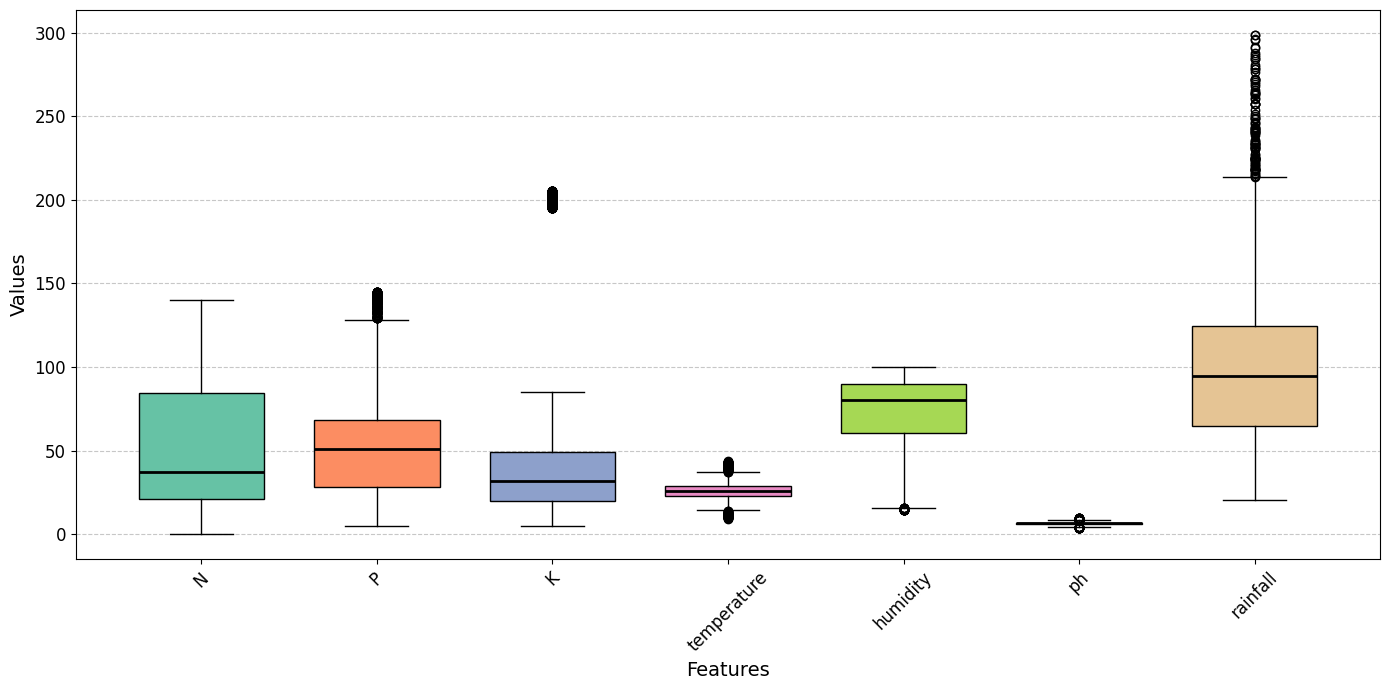

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


CSV_PATH = "/content/drive/MyDrive/Crop_recommendation.csv"  # change if needed
raw = pd.read_csv(CSV_PATH)
FEATURES = ["N", "P", "K", "temperature", "humidity", "ph", "rainfall"]
X = raw[FEATURES].values.astype(np.float32)



#curve visualization

plt.figure(figsize=(14, 7))

colors = sns.color_palette("Set2", len(FEATURES))

# Positions of boxes, closer together
positions = np.arange(1, len(FEATURES) + 1) * 0.7  # factor <1 brings boxes closer

# Data per feature
data_to_plot = [raw[feat] for feat in FEATURES]

bp = plt.boxplot(data_to_plot, positions=positions, widths=0.5, patch_artist=True, medianprops=dict(color='black', linewidth=2))

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')

plt.xticks(positions, FEATURES, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
#plt.title("Distribution of Soil and Climate Features", fontsize=16, fontweight='bold')
plt.ylabel("Values", fontsize=14)
plt.xlabel("Features", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Images/feature_boxplots.png", dpi=300)
plt.show()


# Federated Crop Recommendation – Full Flower Simulation with Extensive Metrics
"""
End‑to‑end federated‑learning experiment comparing two local models:

* **Logistic Soft‑max** (1 Dense layer)
* **MLP** (64‑32‑Soft‑max)

Metrics collected & plotted
---------------------------
1. Mean **training loss** per round (clients)
2. Mean **validation accuracy** per round (clients)
3. **Global test accuracy** per round (server)
4. **Weight Δ (L2)** per round (each model)
5. **Round duration** (s)
6. Final **confusion matrices** (both models)


In [6]:
import os, time, json
import joblib
import tensorflow as tf
import flwr as fl
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# -- load and prepare darta  --
#CSV_PATH = "/content/drive/MyDrive/files_EV/Crop_recommendation.csv"
#raw = pd.read_csv(CSV_PATH)
#FEATURES = ["N", "P", "K", "temperature", "humidity", "ph", "rainfall"]
#X = raw[FEATURES].values.astype(np.float32)
le = LabelEncoder()
y = le.fit_transform(raw["label"].values).astype(np.int64)
scaler = StandardScaler()
X = scaler.fit_transform(X).astype(np.float32)
X_train_full, X_test_global, y_train_full, y_test_global = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)
NUM_CLASSES = len(le.classes_)

# -- Partition helper --
def get_partition(n_clients: int, cid: int):
    idx = np.arange(X_train_full.shape[0])[cid :: n_clients]
    return X_train_full[idx], y_train_full[idx]

# -- Models --
def create_logistic():
    m = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(len(FEATURES),)),
        tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"),
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(5e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])
    return m

def create_mlp():
    m = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(len(FEATURES),)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"),
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])
    return m

# -- Flower Client --
LOCAL_EPOCHS, BATCH_SIZE = 3, 32
import flwr as fl
class CropClient(fl.client.NumPyClient):
    def __init__(self, cid: int, mtype: str):
        self.cid, self.mtype = cid, mtype
        self.model = create_mlp() if mtype == "mlp" else create_logistic()
        Xp, yp = get_partition(NUM_CLIENTS, cid)
        sp = int(0.8*len(Xp))
        self.xtr, self.ytr, self.xval, self.yval = Xp[:sp], yp[:sp], Xp[sp:], yp[sp:]

    def get_parameters(self, _):
        return self.model.get_weights()

    def fit(self, params, _):
        self.model.set_weights(params)
        t0 = time.time()
        hist = self.model.fit(self.xtr, self.ytr, epochs=LOCAL_EPOCHS, batch_size=BATCH_SIZE,
                              validation_data=(self.xval, self.yval), verbose=0)
        dur = time.time()-t0
        return (self.model.get_weights(), len(self.xtr),
                {"loss": hist.history["loss"][-1], "accuracy": hist.history["val_accuracy"][-1], "time": dur})

    def evaluate(self, params, _):
        self.model.set_weights(params)
        loss, acc = self.model.evaluate(self.xval, self.yval, verbose=0)
        return loss, len(self.xval), {"accuracy": acc}

# -- Federated Learning --
NUM_CLIENTS, NUM_ROUNDS = 3, 30

def train_fed(model_type: str):
    logs = {k: [] for k in ["loss","val_acc","g_acc","time"]}
    weight_hist = []
    fin_params = {}

    def client_fn(cid:str): return CropClient(int(cid), model_type)
    gmodel = create_mlp() if model_type == "mlp" else create_logistic()
    init_p = fl.common.ndarrays_to_parameters(gmodel.get_weights())

    class Strategy(fl.server.strategy.FedAvg):
        def aggregate_fit(self, rnd, rs, fs):
            t0 = time.time()
            agg = super().aggregate_fit(rnd, rs, fs)
            t1 = time.time()
            if agg:
                fin_params["w"] = agg[0]
                weight_hist.append(fl.common.parameters_to_ndarrays(agg[0]))
                logs["loss"].append(np.mean([r.metrics["loss"] for _, r in rs]))
                logs["val_acc"].append(np.mean([r.metrics["accuracy"] for _, r in rs]))
                gmodel.set_weights(weight_hist[-1])
                _, gacc = gmodel.evaluate(X_test_global, y_test_global, verbose=0)
                logs["g_acc"].append(gacc)
                logs["time"].append(t1 - t0)
            return agg

    fl.simulation.start_simulation(client_fn=client_fn, num_clients=NUM_CLIENTS,
                                   config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
                                   strategy=Strategy(initial_parameters=init_p))
    gmodel.set_weights(weight_hist[-1])
    return logs, weight_hist, gmodel

# -- Main --
if __name__ == "__main__":
    for gpu in tf.config.list_physical_devices("GPU"):
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError:
            pass

    log_log, wlog, model_log = train_fed("logistic")
    log_mlp, wmlp, model_mlp = train_fed("mlp")

    # Saves
    np.save('/content/drive/MyDrive/Images/log_log.npy', log_log)
    np.save('/content/drive/MyDrive/Images/log_mlp.npy', log_mlp)
    joblib.dump(wlog, '/content/drive/MyDrive/Images/wlog.pkl')
    joblib.dump(wmlp, '/content/drive/MyDrive/Images/wmlp.pkl')
    model_log.save('/content/drive/MyDrive/Images/model_log.h5')
    model_mlp.save('/content/drive/MyDrive/Images/model_mlp.h5')
    joblib.dump(scaler, '/content/drive/MyDrive/Images/scaler.pkl')
    np.save('/content/drive/MyDrive/Images/le_classes.npy', le.classes_)
    np.save('/content/drive/MyDrive/Images/X_test_global.npy', X_test_global)
    np.save('/content/drive/MyDrive/Images/y_test_global.npy', y_test_global)

    print("End of training and models saved.")


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=30, no round_timeout
2025-06-24 12:24:28,115	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resource

End of training and models saved.


Plot all the requiered curves

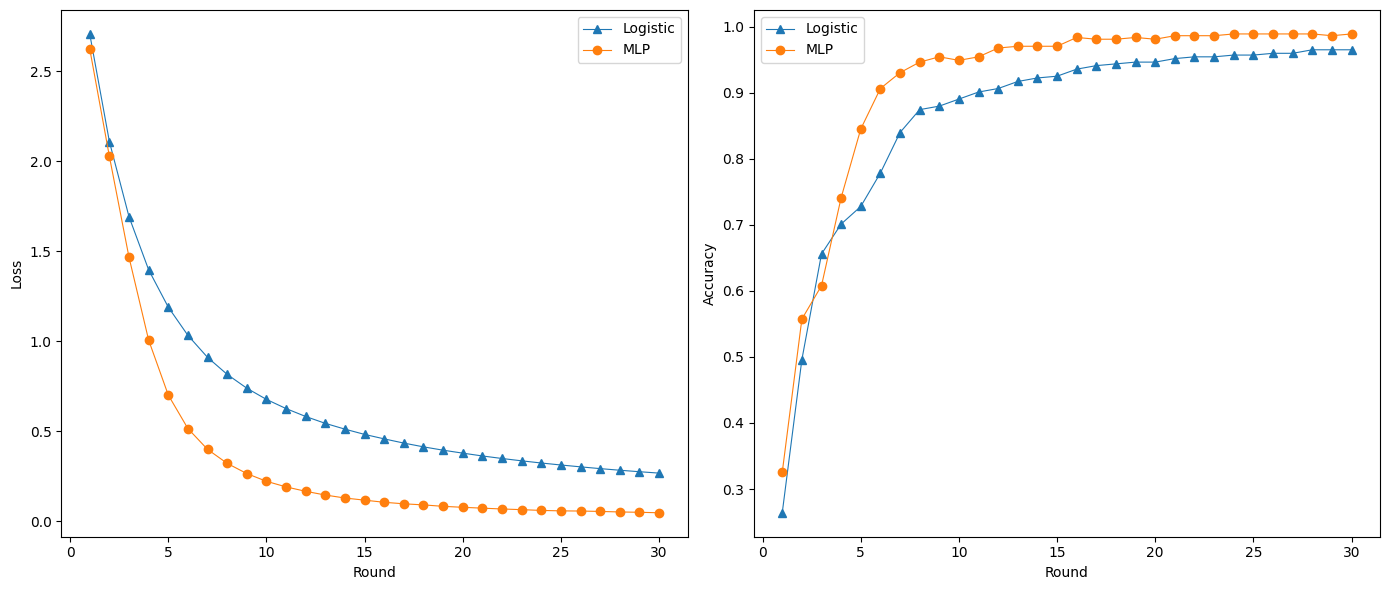

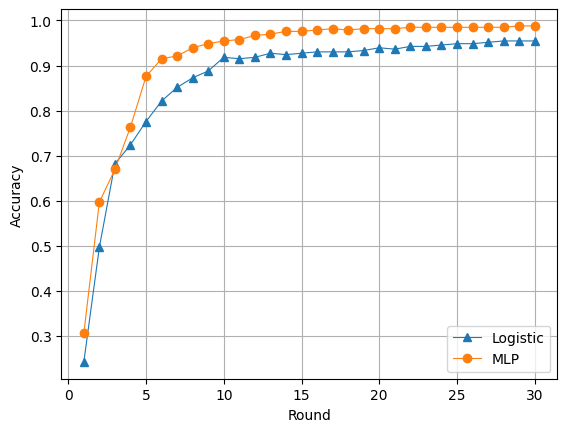

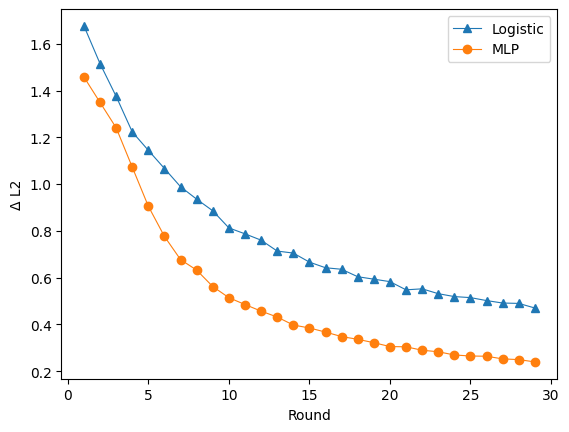

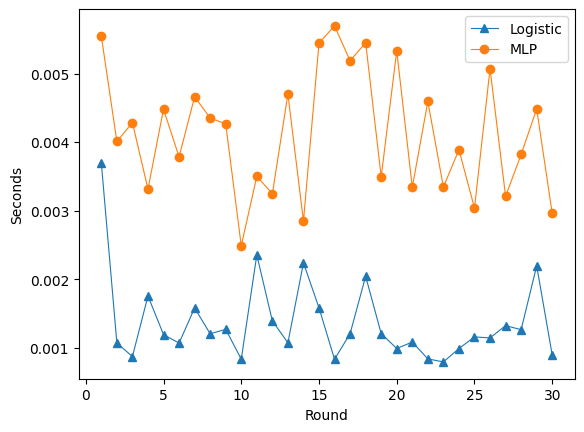

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


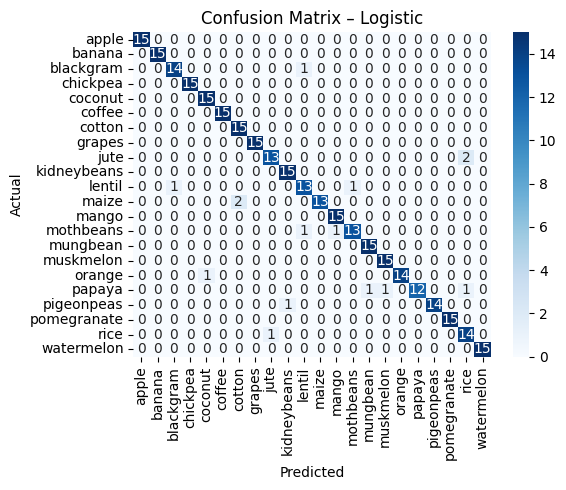

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


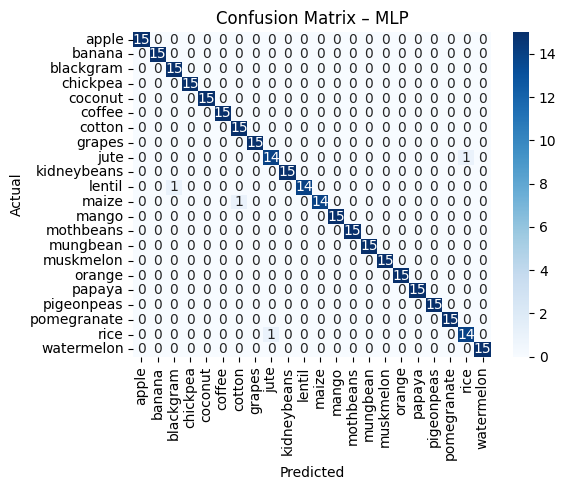

30 30
[0.9545454382896423, 0.9545454382896423, 0.9545454382896423]
[0.9848484992980957, 0.9878787994384766, 0.9878787994384766]


In [7]:

from sklearn.metrics import confusion_matrix

# Chargement des artefacts
log_log = np.load('log_log.npy', allow_pickle=True).item()
log_mlp = np.load('log_mlp.npy', allow_pickle=True).item()
wlog = joblib.load('wlog.pkl')
wmlp = joblib.load('wmlp.pkl')
model_log = tf.keras.models.load_model('model_log.h5')
model_mlp = tf.keras.models.load_model('model_mlp.h5')
le_classes = np.load('le_classes.npy',allow_pickle=True)
X_test_global = np.load('X_test_global.npy')
y_test_global = np.load('y_test_global.npy')

NUM_ROUNDS = len(log_log["loss"])
rnds = np.arange(1, NUM_ROUNDS + 1)

# 1‑2. Loss & Val‑Acc
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(rnds, log_log["loss"], linestyle='-', marker='^', label='Logistic',linewidth=0.8)
plt.plot(rnds, log_mlp["loss"], linestyle='-', marker='o', label='MLP',linewidth=0.8)
#plt.title('Mean Loss per Round')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(rnds, log_log["val_acc"], linestyle='-', marker='^', label='Logistic',linewidth=0.8)
plt.plot(rnds, log_mlp["val_acc"], linestyle='-', marker='o', label='MLP',linewidth=0.8)
#plt.title('Mean Validation Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('loss_valacc.png')
plt.show()

# 3. Global Test Accuracy per Round
plt.figure()
plt.plot(rnds, log_log["g_acc"], linestyle='-', marker='^', label='Logistic',linewidth=0.8)
plt.plot(rnds, log_mlp["g_acc"], linestyle='-', marker='o', label='MLP',linewidth=0.8)
#plt.title('Global Test Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig('global_acc.png')
plt.show()

# 4. Weight Δ (L2) per Round
plt.figure()
for w_hist, label in [(wlog, 'Logistic'), (wmlp, 'MLP')]:
    deltas = [
        np.linalg.norm(
            np.concatenate([w.flatten() for w in w_hist[i]]) -
            np.concatenate([w.flatten() for w in w_hist[i-1]])
        )
        for i in range(1, len(w_hist))
    ]
    plt.plot(np.arange(1, len(deltas) + 1), deltas, linestyle='-',linewidth=0.8, marker='o' if label == 'MLP' else '^', label=label)
#plt.title('Weight Δ (L2) per Round')
plt.xlabel('Round')
plt.ylabel('Δ L2')
plt.legend()
#plt.grid()
plt.savefig('weight_deltas.png')
plt.show()

# 5. Round Duration
plt.figure()
plt.plot(rnds, log_log["time"], linestyle='-', marker='^', label='Logistic',linewidth=0.8)
plt.plot(rnds, log_mlp["time"], linestyle='-', marker='o', label='MLP',linewidth=0.8)
#plt.title('Round Duration')
plt.xlabel('Round')
plt.ylabel('Seconds')
plt.legend()
#plt.grid()
plt.savefig('round_time.png')
plt.show()

# 6. Confusion matrices
for mdl, lbl in [(model_log, 'Logistic'), (model_mlp, 'MLP')]:
    y_pred = np.argmax(mdl.predict(X_test_global), axis=1)
    cm = confusion_matrix(y_test_global, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_classes, yticklabels=le_classes)
    plt.title(f'Confusion Matrix – {lbl}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f'cm_{lbl.lower()}.png')
    plt.show()
print(len(log_log["g_acc"]), len(log_mlp["g_acc"]))
print(log_log["g_acc"][27:])
print(log_mlp["g_acc"][27:])

In [ ]:
import numpy as np
data = np.load('log_log.npy', allow_pickle=True)
print(type(data))
print(data)

<class 'numpy.ndarray'>
{'loss': [np.float64(2.4276253382364907), np.float64(1.904369831085205), np.float64(1.551975925763448), np.float64(1.3041633764902751), np.float64(1.1210928757985432), np.float64(0.9813779791196188), np.float64(0.8766571084658304), np.float64(0.791921595732371), np.float64(0.7239531477292379), np.float64(0.6658487319946289), np.float64(0.6170367201169332), np.float64(0.5761415759722391), np.float64(0.5407479405403137), np.float64(0.5093958973884583), np.float64(0.4808628459771474), np.float64(0.45606036980946857), np.float64(0.4337019622325897), np.float64(0.4126741786797841), np.float64(0.3956260184446971), np.float64(0.37903161843617755), np.float64(0.36331677436828613), np.float64(0.3499407271544139), np.float64(0.3372395733992259), np.float64(0.32482139269510907), np.float64(0.3138059973716736), np.float64(0.3030390838781993), np.float64(0.29365845521291095), np.float64(0.2844795385996501), np.float64(0.2757713794708252), np.float64(0.26846324404080707)], 'v